In [10]:
from datetime import datetime as dt
from glob import glob as glob
import torch as tr
import numpy as np

import itertools
from sklearn.metrics import pairwise_distances

from Nback_tasks import ItemRecognitionTask
from Nback_models import ItemRecognitionEM
import context_tools as ct

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size':22})

%load_ext autoreload
%reload_ext autoreload
%autoreload 2


def mov_avg(arr,wind=5000):
  ma = -np.ones(len(arr)-wind)
  for idx in range(len(arr)-wind):
    ma[idx] = arr[idx:idx+wind].mean()
  return ma

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# train and eval item recognition model

In [401]:
maxsoftmax = lambda ulog: tr.argmax(tr.softmax(ulog,-1),-1)

def run_model(net,task,neps,ntrials,setsize,training=True,verb=True):
  
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)

  score = -np.ones([neps,ntrials])
  loss = -np.ones([neps])

  for ep in range(neps):
#     task.sample_stokens()
    # gen stim, forward prop
    C,S,ytarget = task.gen_exp_data(ntrials,setsize)
    yhat = net(C,S)
    # forward prop
    score[ep] = (maxsoftmax(yhat) == ytarget).squeeze()
    ep_loss = 0
    for trial in range(ntrials):
      tr_loss = lossop(yhat[trial],ytarget[trial])
      ep_loss += tr_loss
    # back prop
    if training:
      optiop.zero_grad()
      ep_loss.backward(retain_graph=True)
      optiop.step()
    # record 
    loss[ep] = ep_loss
    # print
    if verb and ep%(neps/10)==0:
      print('loss',ep/neps,ep_loss.detach().numpy())
  return loss,score

In [467]:
## init
seed = 0
sedim = 8
cedim = 2
stsize = 20
emthresh = 1
net = ItemRecognitionEM(sedim,cedim,stsize,emthresh,seed)
ntrials = 10
setsize = 3
stimset = ntrials*setsize+20
task = ItemRecognitionTask(sedim,cedim,stimset,seed)

In [468]:
## train
tr_neps = 100000
tr_loss,trsc = run_model(net,task,tr_neps,ntrials,setsize,training=True)

loss 0.0 6.8778386
loss 0.1 5.9820457
loss 0.2 6.205368
loss 0.3 6.8603964
loss 0.4 1.4052542
loss 0.5 6.4233637
loss 0.6 4.951271
loss 0.7 0.8284097
loss 0.8 3.282886
loss 0.9 6.552182


(0.4, 1)

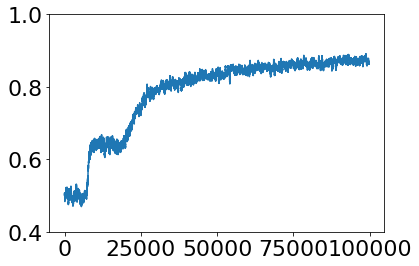

In [469]:
tracc = mov_avg(trsc.mean(-1),200)
plt.plot(tracc)
plt.ylim(0.4,1)

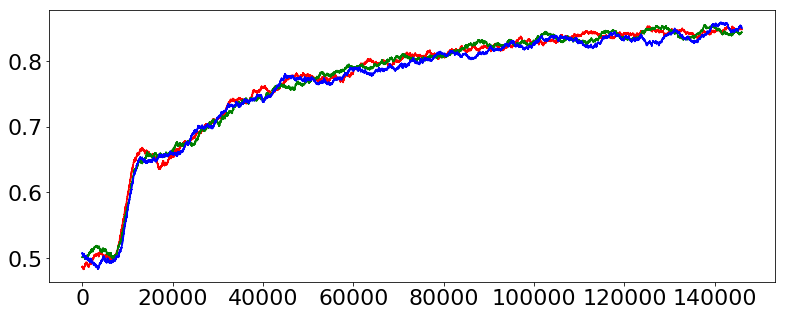

In [229]:
plt.figure(figsize=(13,5))
cL = ['r','g','b']
for t in range(3):
  plt.plot(mov_avg(trsc[:,t],4000),c=cL[t])

In [357]:
net.emthresh = .15
itr = 1000
evsc = -np.ones([itr,setsize])
for pos in range(1,5):
#   print(pos)
  for i in range(itr):
    C,X,yt = task.gen_serial_position_trial(setsize,pos)
    yh = net(C,X)
    evsc[i,pos-1] = (maxsoftmax(yh) == yt).squeeze()


(0, 1)

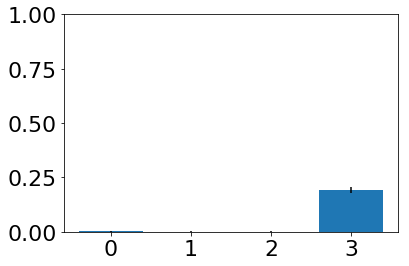

In [358]:
ac = evsc.mean(0)
s = evsc.std(0)/np.sqrt(itr)
plt.bar(np.arange(len(ac)),ac,yerr=s)
plt.ylim(0,1)

### debug prints

In [459]:
sedim = 2
cedim = 2
stsize = 25
emthresh = 1
seed = np.random.randint(999)
task = ItemRecognitionTask(sedim,cedim,ntokens=150,seed=seed)
net = ItemRecognitionEM(sedim,cedim,stsize,emthresh,seed=seed)
ntrials = 3
setsize = 2
tr_neps = 1
_ = run_model(net,task,tr_neps,ntrials,setsize,training=True,verb=True)

tensor([0.2348, 0.1000])
tensor([1.0580, 1.0182, 0.2443, 0.1553])
tensor([2.0281, 2.0079, 1.0252, 1.0080, 0.2000, 0.1395])
loss 0.0 2.0587277


# load and analyze IR model

## plot param sweep noiseless

In [12]:
def load_trsc(emthresh,ntrials,setsize,seed):
  gfpath = 'LSTM_25-emthresh_%i-ntrials_%i-setsize_%i-seed_%i-noiseless-trsc.npy'%(emthresh,ntrials,setsize,seed)
  try:
    trsc = np.load('model_data/IRsweep_noiseless/'+gfpath)
  except:
    print('load er',gfpath)
    return None
  return trsc

def plot_train_acc(ntrials,setsize):
  """ loop emthresh
  """
  plt.close('all')
  emL = [1,2,3]
  seedL = [1,2,3,4,5]
  fig,axarr = plt.subplots(3,1,figsize=(20,32));axarr=axarr.reshape(-1)
  for ax,emthresh in zip(axarr,emL):
    ax.set_ylim(0.45,1.01)
    ax.set_title('emthresh %i'%emthresh)
    ax.grid(True)
    for seed in seedL:
      trsc = load_trsc(emthresh,ntrials,setsize,seed)
      if type(trsc)==type(None): continue
      tracc = mov_avg(trsc.mean(-1),2000)
      ax.plot(tracc)
    ax.set_xlabel('train epoch')
    ax.set_ylabel('accuracy train set')
  

## train acc

In [ ]:
ntL = [2,3,4,5,10,15,20]
ssL = [3,4,5,6]

# ntL = ntL[:1]
# ssL = ssL[:1]

for ntrials,setsize in itertools.product(ntL,ssL):
  plot_train_acc(ntrials,setsize)
  title = 'ntrials%isetsize%i'%(ntrials,setsize)
  plt.suptitle(title)
  plt.savefig('figures/IRsweep_noiseless/train_acc/'+title)

### setsize

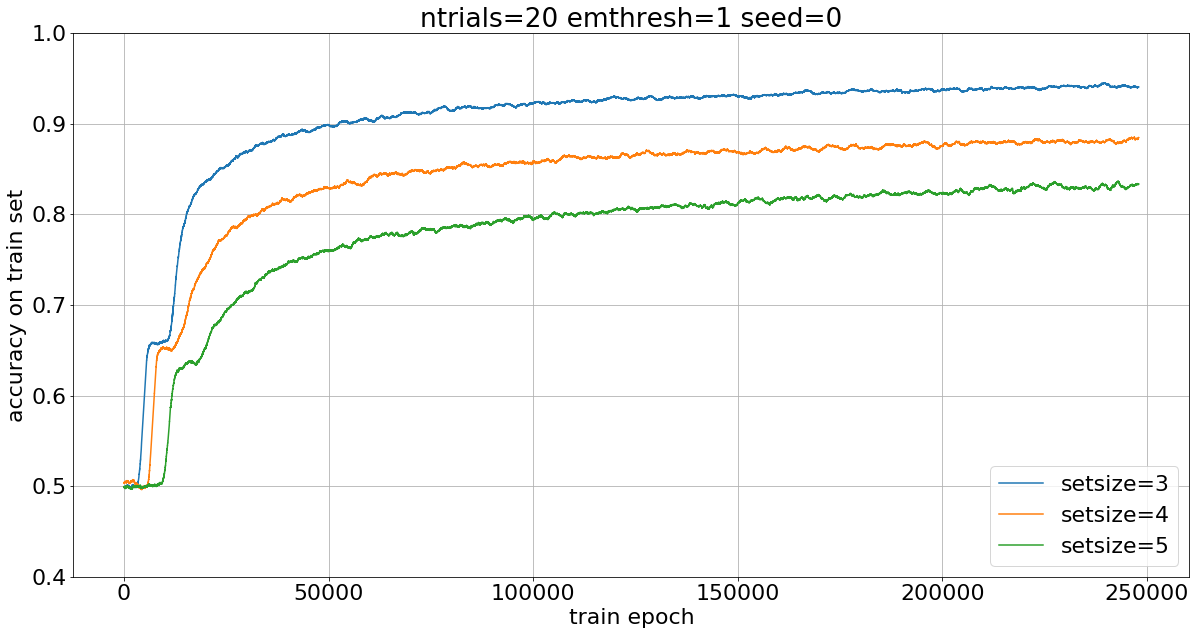

In [133]:
seed = 0
emthresh = 1
ntrials = 20
ssL = [3,4,5]
plt.figure(figsize=(20,10))
for setsize in ssL:
  trsc = load_trsc(emthresh,ntrials,setsize,seed)
  tracc = mov_avg(trsc.mean(-1),2000)
  plt.plot(tracc,label='setsize=%i'%setsize)

plt.title('ntrials=%i emthresh=%i seed=%i'%(ntrials,emthresh,seed))
plt.legend()
plt.ylim(0.4,1)
plt.grid(True)
plt.xlabel('train epoch')
plt.ylabel('accuracy on train set')
plt.savefig('figures/IRsweep_noiseless/train_setsize')

### serial position
- need task method that constructs trial with match at specified serial position 

In [211]:
## init
seed = 0
sedim = 10
cedim = 2
stsize = 25
emthresh = 1
stimset = 150
task = ItemRecognitionTask(sedim,cedim,stimset,seed)
net = ItemRecognitionEM(sedim,cedim,stsize,emthresh,seed)

In [213]:
setsize,match_position = 4,4
C,X,Y = task.gen_serial_position_trial(setsize,match_position)

In [214]:
net(C,X)

tensor([[[-0.0401,  0.0939]]], grad_fn=<CopySlices>)

# old

## plot param sweep 1

In [216]:
def load_concat_tracc(emthresh,ntrials,setsize,seed):
  """ loads train data from single subject
  """ 
  trepL = range(5,46,5)
  trsc = -np.ones([len(trepL)*50000,ntrials])
  for trep in trepL:
    trep*=10000
    gfpath = "LSTM_25-emthresh_%s-ntrials_%s-setsize_%s-seed_%s-tr_%i-trsc.npy"%(
      emthresh,ntrials,setsize,seed,trep)
    try:
      trsc_t = np.load('model_data/IRsweep/'+gfpath)
      trsc[trep-50000:trep] = trsc_t
    except:
      pass
      print('e',gfpath)
  return trsc

def plot_train_acc(emthresh,ntrials,setsize):
  """ loads and plot train data from every seed 
  """
  seedL = range(2)
  fig,axarr = plt.subplots(5,2,figsize=(30,30)); axarr=axarr.reshape(-1)
  plt.suptitle('emthresh%i ntrials%i setsize%i'%(emthresh,ntrials,setsize))
  for ax,seed in zip(axarr,seedL):
    trsc = load_concat_tracc(emthresh,ntrials,setsize,seed)
    tracc = mov_avg(trsc.mean(-1),2000)
    ax.plot(tracc)
    ax.set_title('S%.2i'%seed)
    ax.set_ylim(.2,.8)
  return None

def plot_train_acc2(ntrials,setsize):
  """ 
  different ax for each emthresh
  different seeds plotted with different colors on same ax
  """
  emL = range(10)
  seedL = range(4)
  fig,axarr = plt.subplots(5,2,figsize=(30,30));axarr=axarr.reshape(-1)
  plt.suptitle('ntrials%i-setsize%i'%(ntrials,setsize),fontsize=60)
  for ax,emthresh in zip(axarr,emL):
    ax.set_title('emthresh%i'%emthresh)
    ax.grid(True)
    ax.set_ylim(0.4,1.05)
    for seed in seedL:
      trsc = load_concat_tracc(emthresh,ntrials,setsize,seed)
      tracc = mov_avg(trsc.mean(-1),2000)
      ax.plot(tracc)
  return None

10 3
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_0-ntrials_10-setsize_3-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_1-ntrials_10-setsize_3-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_1-ntrials_10-setsize_3-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_1-ntrials_10-setsize_3-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_1-ntrials_10-setsize_3-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_1-ntrials_10-setsize_3-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_1-ntrials_10-setsize_3-see

e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_9-ntrials_10-setsize_3-seed_3-t

e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_3-t

e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_7-ntrials_10-setsize_5-seed_3-t

e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_300000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_350000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_400000-trsc.npy
e LSTM_25-emthresh_5-ntrials_10-setsize_6-seed_3-tr_450000-trsc.npy
e LSTM_25-emthresh_6-ntrials_10-setsize_6-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_6-ntrials_10-setsize_6-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_6-ntrials_10-setsize_6-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_6-ntrials_10-setsize_6-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_6-ntrials_10-setsize_6-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_6-ntrials_10-setsize_6-seed_2-t

e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_4-ntrials_15-setsize_3-seed_3-t

e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_2-ntrials_15-setsize_4-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_3-ntrials_15-setsize_4-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_3-ntrials_15-setsize_4-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_3-ntrials_15-setsize_4-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_3-ntrials_15-setsize_4-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_3-ntrials_15-setsize_4-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_3-ntrials_15-setsize_4-seed_2-t

15 5
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_0-ntrials_15-setsize_5-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_1-ntrials_15-setsize_5-see

e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_300000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_350000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_400000-trsc.npy
e LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_3-tr_450000-trsc.npy
e LSTM_25-emthresh_9-ntrials_15-setsize_5-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_9-ntrials_15-setsize_5-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_9-ntrials_15-setsize_5-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_9-ntrials_15-setsize_5-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_9-ntrials_15-setsize_5-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_9-ntrials_15-setsize_5-seed_2-t

e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_7-ntrials_15-setsize_6-seed_3-t

e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_300000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_350000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_400000-trsc.npy
e LSTM_25-emthresh_5-ntrials_20-setsize_3-seed_3-tr_450000-trsc.npy
e LSTM_25-emthresh_6-ntrials_20-setsize_3-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_6-ntrials_20-setsize_3-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_6-ntrials_20-setsize_3-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_6-ntrials_20-setsize_3-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_6-ntrials_20-setsize_3-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_6-ntrials_20-setsize_3-seed_2-t

e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_50000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_100000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_150000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_200000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_250000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_300000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_350000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_400000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_2-tr_450000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_3-tr_50000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_3-tr_100000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_3-tr_150000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_3-tr_200000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_3-tr_250000-trsc.npy
e LSTM_25-emthresh_4-ntrials_20-setsize_4-seed_3-t

KeyboardInterrupt: 

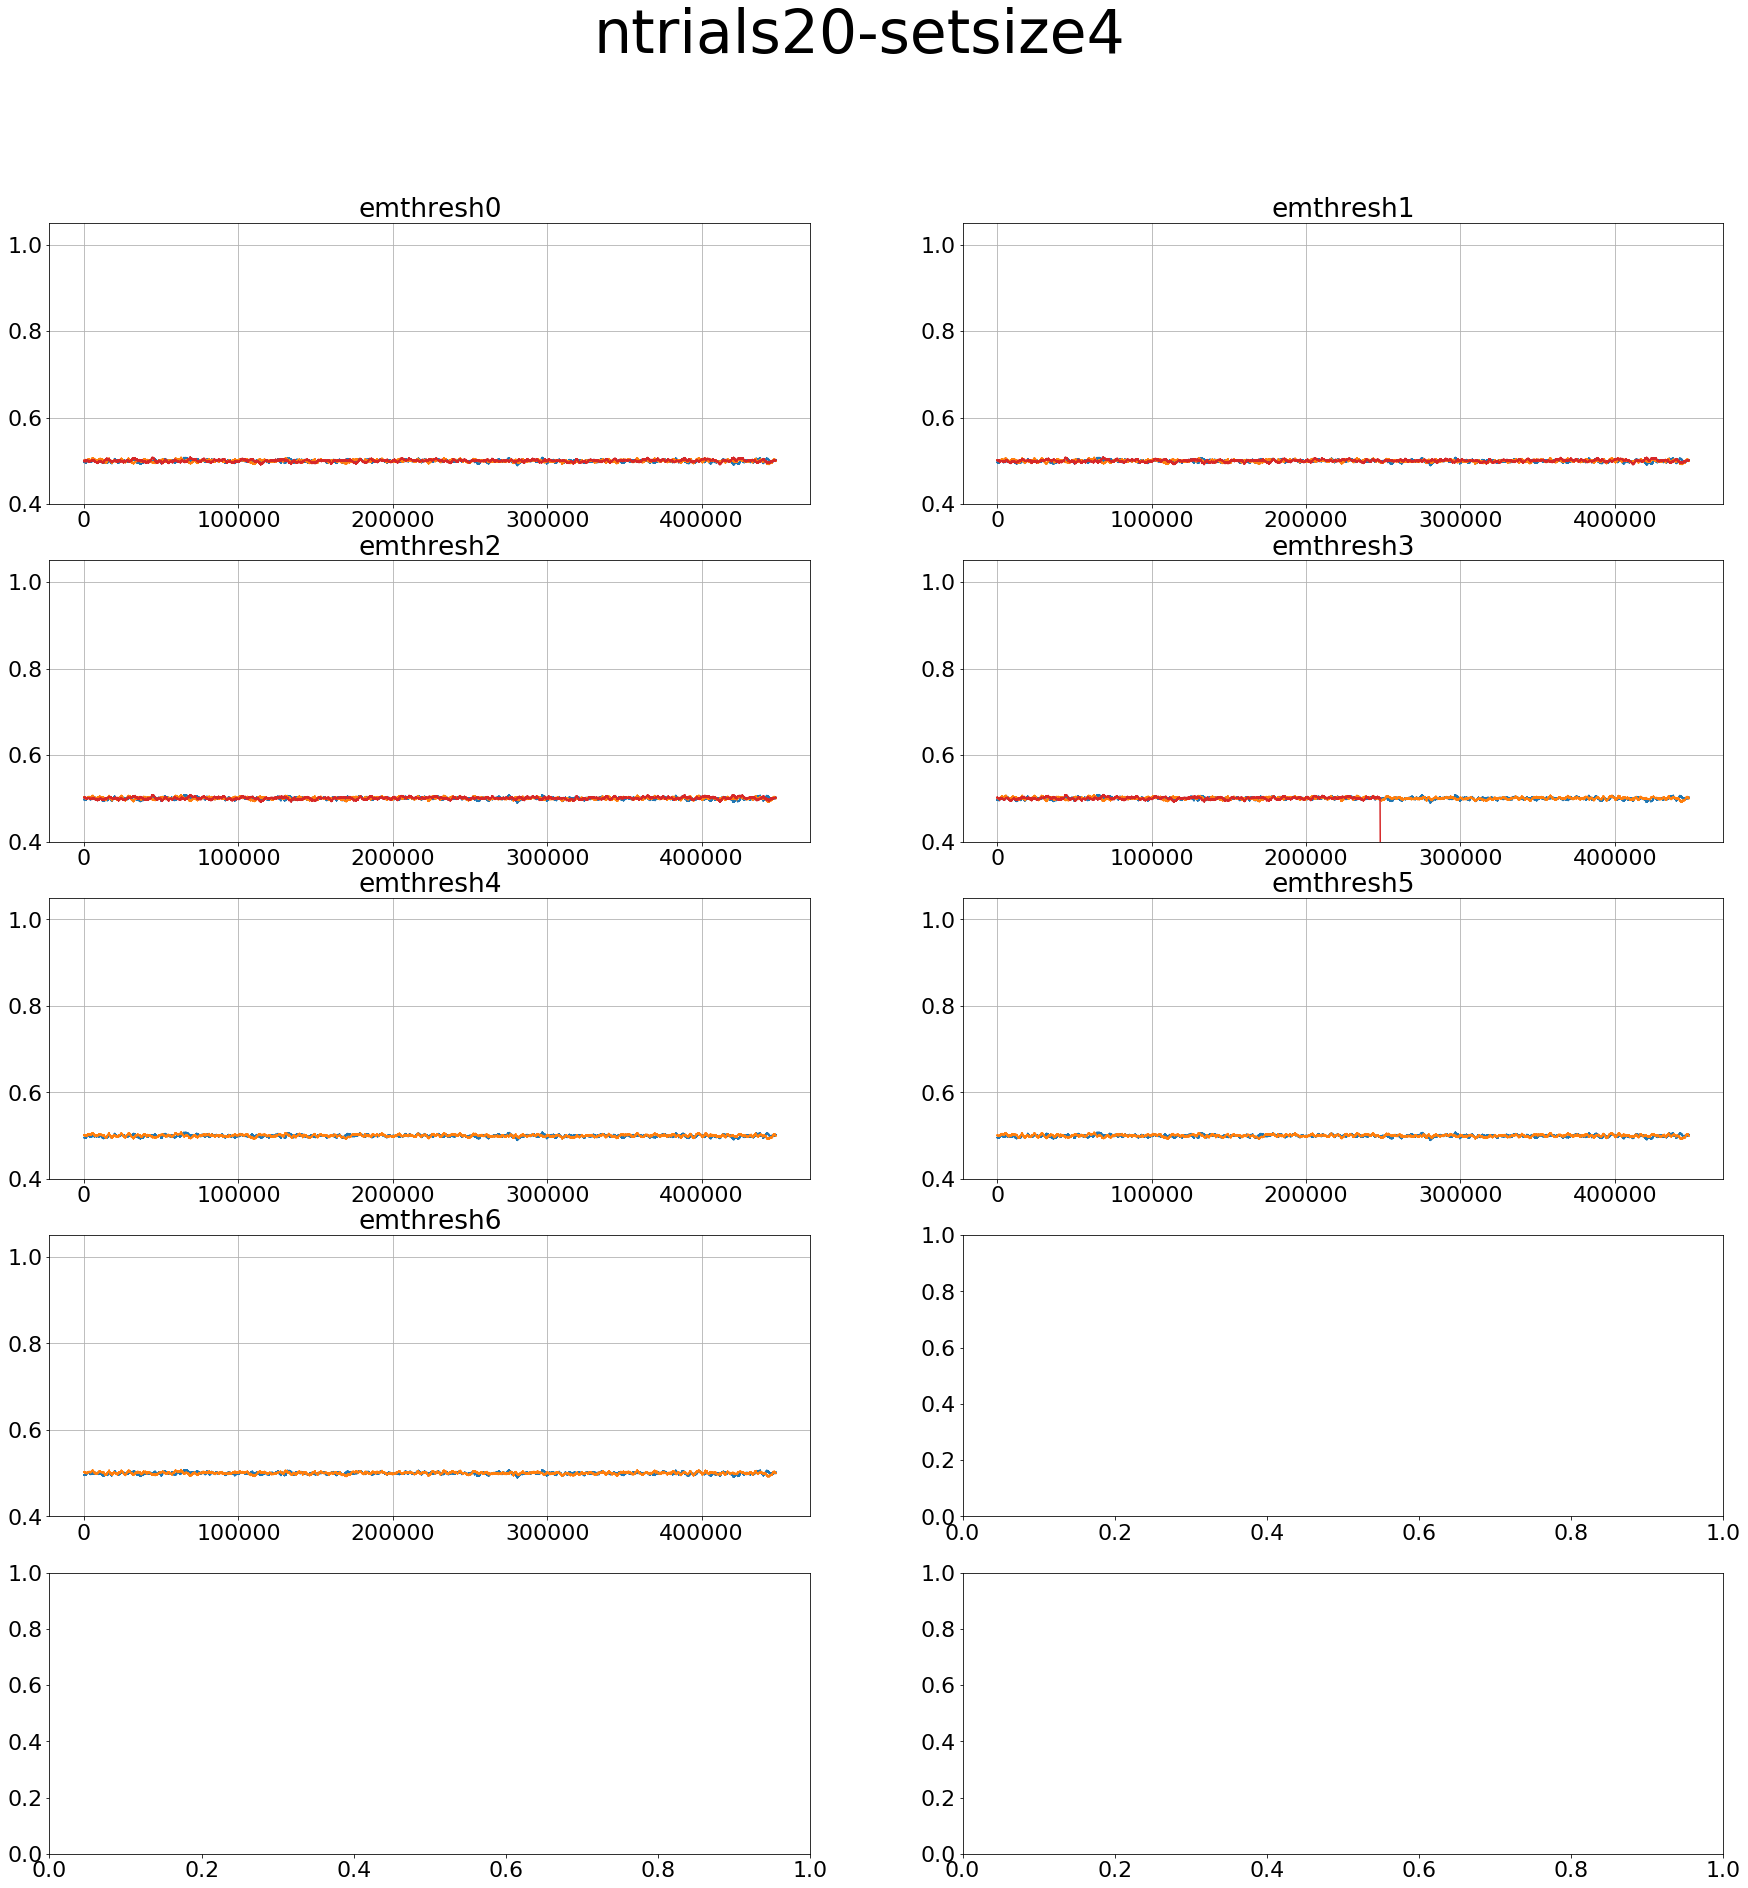

In [218]:
ntL = [2,3,4,5,10,15,20]
ntL = [10,15,20]
ssL = [3,4,5,6]
for ntrials,setsize in itertools.product(ntL,ssL):
  print(ntrials,setsize)
  plot_train_acc2(ntrials,setsize)
  plt.savefig('figures/IRsweep/train_acc/ntrials%isetsize%i'%(ntrials,setsize))
  plt.close('all')

0 2 3
0 2 4
0 2 5
0 2 6
0 3 3
0 3 4
0 3 5
0 3 6
0 4 3
0 4 4
0 4 5
0 4 6
0 5 3
0 5 4
0 5 5
0 5 6
0 10 3
0 10 4
0 10 5
0 10 6
0 15 3
0 15 4
0 15 5
0 15 6
0 20 3
0 20 4
0 20 5
0 20 6
1 2 3
1 2 4
1 2 5
1 2 6
1 3 3
1 3 4
1 3 5
1 3 6
1 4 3
1 4 4
1 4 5
1 4 6
1 5 3
1 5 4
1 5 5
1 5 6
1 10 3
1 10 4
1 10 5
1 10 6
1 15 3
1 15 4
1 15 5
1 15 6
1 20 3
1 20 4
1 20 5
1 20 6
2 2 3
2 2 4
2 2 5
2 2 6
2 3 3
2 3 4
2 3 5
2 3 6
2 4 3
2 4 4
2 4 5
2 4 6
2 5 3
2 5 4
2 5 5
2 5 6
2 10 3
2 10 4
2 10 5
2 10 6
2 15 3
2 15 4
2 15 5
2 15 6
2 20 3
2 20 4
2 20 5
2 20 6
3 2 3
3 2 4
3 2 5
3 2 6
3 3 3
3 3 4
3 3 5
3 3 6
3 4 3


KeyboardInterrupt: 

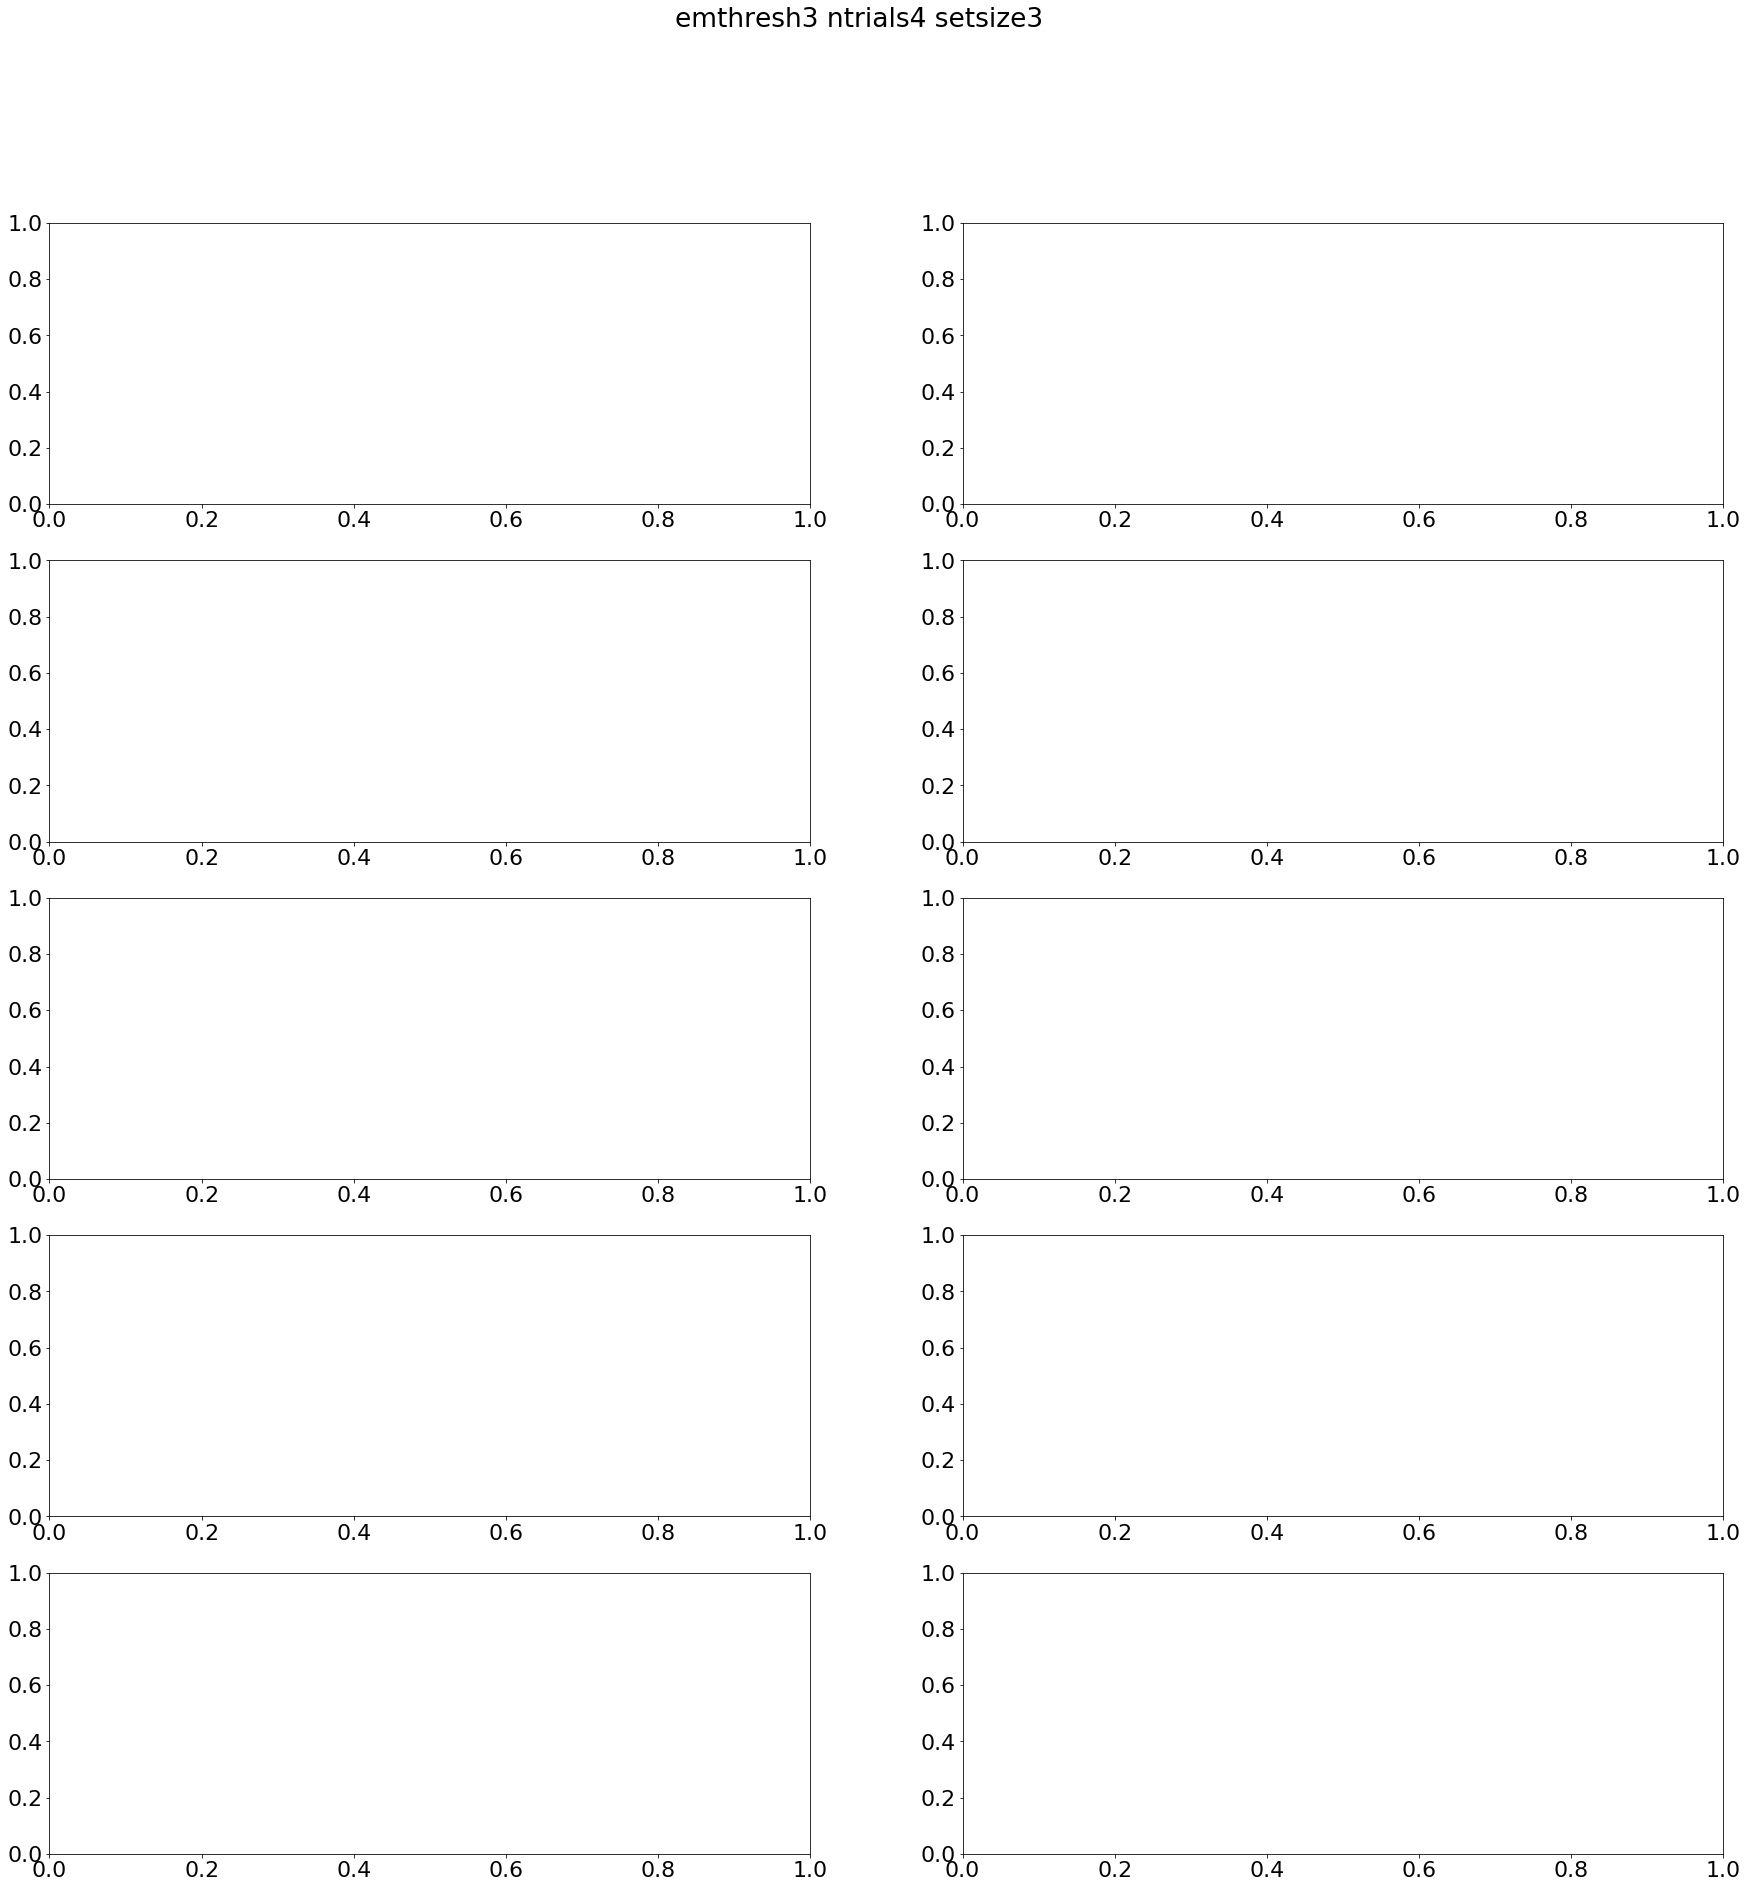

In [61]:
emL = range(11)
ntL = [2,3,4,5,10,15,20]
ssL = [3,4,5,6]
seedL = range(3)

for emthresh,ntrials,setsize in itertools.product(emL,ntL,ssL):
  print(emthresh,ntrials,setsize)
  plot_train_acc(emthresh,ntrials,setsize)
  plt.savefig('figures/IRsweep/train_acc/emthresh%i-ntrials%isetsize%i'%(emthresh,ntrials,setsize))
  plt.close('all')

In [157]:
emL = range(11)
ntL = [2,3,4,5,10,15,20]
ssL = [3,4,5,6]
seedL = range(3)

# emL = [0]
# ntL = [2,3,5]
# ssL = [3]
# seedL = [0]

trepL = range(5,46,5)
for emthresh,ntrials,setsize,seed in itertools.product(emL,ntL,ssL,seedL):
  print('loop',emthresh,ntrials,setsize,seed)
  trsc = -np.ones([len(trepL)*50000,ntrials])
  for trep in trepL:
    trep*=10000
    gfpath = "LSTM_25-emthresh_%s-ntrials_%s-setsize_%s-seed_%s-tr_%i-trsc.npy"%(
      emthresh,ntrials,setsize,seed,trep)
    try:
      trsc_t = np.load('model_data/IRsweep/'+gfpath)
    except:
      pass
      print('e',gfpath)
    trsc[trep-50000:trep] = trsc_t

  tracc = mov_avg(trsc.mean(-1))

  plt.figure(figsize=(16,8))
  ax=plt.gca()
  ax.set_ylabel('train accuracy')
  ax.set_xlabel('train epoch')
  ax.plot(tracc)
  # save
  plt.savefig('figures/IRsweep/train_acc/'+gfpath[:-4])
  plt.close('all')

loop 0 2 3 0
loop 0 2 3 1
loop 0 2 3 2
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (50000, 2) 350000 400000 (50000, 2)
e (50000, 2) 400000 450000 (50000, 2)
loop 0 2 4 0
loop 0 2 4 1
loop 0 2 4 2
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (50000, 2) 350000 400000 (50000, 2)
e (50000, 2) 400000 450000 (50000, 2)
loop 0 2 5 0
loop 0 2 5 1
loop 0 2 5 2
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50

loop 0 15 5 0
loop 0 15 5 1
loop 0 15 5 2
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50000, 15)
e (50000, 15) 300000 350000 (50000, 15)
e (50000, 15) 350000 400000 (50000, 15)
e (50000, 15) 400000 450000 (50000, 15)
loop 0 15 6 0
loop 0 15 6 1
loop 0 15 6 2
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50000, 15)
e (50000, 15) 300000 350000 (50000, 15)
e (50000, 15) 350000 400000 (50000, 15)
e (50000, 15) 400000 450000 (50000, 15)
loop 0 20 3 0
loop 0 20 3 1
loop 0 20 3 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 2

loop 1 10 3 0
loop 1 10 3 1
loop 1 10 3 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 1 10 4 0
loop 1 10 4 1
loop 1 10 4 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 1 10 5 0
loop 1 10 5 1
loop 1 10 5 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 2

loop 2 4 5 0
loop 2 4 5 1
loop 2 4 5 2
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000 400000 (50000, 4)
e (50000, 4) 400000 450000 (50000, 4)
loop 2 4 6 0
loop 2 4 6 1
loop 2 4 6 2
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000 400000 (50000, 4)
e (50000, 4) 400000 450000 (50000, 4)
loop 2 5 3 0
loop 2 5 3 1
loop 2 5 3 2
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50

loop 3 3 3 0
loop 3 3 3 1
loop 3 3 3 2
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 3 3 4 0
loop 3 3 4 1
loop 3 3 4 2
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 3 3 5 0
loop 3 3 5 1
loop 3 3 5 2
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50

loop 3 20 4 0
loop 3 20 4 1
e (50000, 20) 400000 450000 (50000, 20)
loop 3 20 4 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 3 20 5 0
loop 3 20 5 1
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 3 20 5 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 3 20 

loop 4 10 5 0
loop 4 10 5 1
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 4 10 5 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 4 10 6 0
loop 4 10 6 1
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 4 10 6 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 

loop 5 3 3 0
loop 5 3 3 1
loop 5 3 3 2
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 5 3 4 0
loop 5 3 4 1
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 5 3 4 2
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 5 3 5 0
loop 5 3 5 1
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50

loop 5 10 4 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 5 10 5 0
loop 5 10 5 1
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 5 10 5 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50

loop 6 2 4 0
loop 6 2 4 1
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (50000, 2) 350000 400000 (50000, 2)
e (50000, 2) 400000 450000 (50000, 2)
loop 6 2 4 2
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (50000, 2) 350000 400000 (50000, 2)
e (50000, 2) 400000 450000 (50000, 2)
loop 6 2 5 0
loop 6 2 5 1
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (500

loop 6 5 4 0
loop 6 5 4 1
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50000, 5)
e (50000, 5) 300000 350000 (50000, 5)
e (50000, 5) 350000 400000 (50000, 5)
e (50000, 5) 400000 450000 (50000, 5)
loop 6 5 4 2
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50000, 5)
e (50000, 5) 300000 350000 (50000, 5)
e (50000, 5) 350000 400000 (50000, 5)
e (50000, 5) 400000 450000 (50000, 5)
loop 6 5 5 0
loop 6 5 5 1
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50000, 5)
e (50000, 5) 300000 350000 (50000, 5)
e (500

loop 6 20 3 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 6 20 4 0
loop 6 20 4 1
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 6 20 4 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50

loop 7 4 3 0
loop 7 4 3 1
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000 400000 (50000, 4)
e (50000, 4) 400000 450000 (50000, 4)
loop 7 4 3 2
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000 400000 (50000, 4)
e (50000, 4) 400000 450000 (50000, 4)
loop 7 4 4 0
loop 7 4 4 1
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (500

loop 7 10 6 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 7 15 3 0
loop 7 15 3 1
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50000, 15)
e (50000, 15) 300000 350000 (50000, 15)
e (50000, 15) 350000 400000 (50000, 15)
e (50000, 15) 400000 450000 (50000, 15)
loop 7 15 3 2
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50000, 15)
e (50

loop 8 2 6 0
loop 8 2 6 1
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (50000, 2) 350000 400000 (50000, 2)
e (50000, 2) 400000 450000 (50000, 2)
loop 8 2 6 2
e (50000, 2) 0 50000 (50000, 2)
e (50000, 2) 50000 100000 (50000, 2)
e (50000, 2) 100000 150000 (50000, 2)
e (50000, 2) 150000 200000 (50000, 2)
e (50000, 2) 200000 250000 (50000, 2)
e (50000, 2) 250000 300000 (50000, 2)
e (50000, 2) 300000 350000 (50000, 2)
e (50000, 2) 350000 400000 (50000, 2)
e (50000, 2) 400000 450000 (50000, 2)
loop 8 3 3 0
loop 8 3 3 1
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (500

loop 8 5 6 0
loop 8 5 6 1
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50000, 5)
e (50000, 5) 300000 350000 (50000, 5)
e (50000, 5) 350000 400000 (50000, 5)
e (50000, 5) 400000 450000 (50000, 5)
loop 8 5 6 2
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50000, 5)
e (50000, 5) 300000 350000 (50000, 5)
e (50000, 5) 350000 400000 (50000, 5)
e (50000, 5) 400000 450000 (50000, 5)
loop 8 10 3 0
loop 8 10 3 1
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (5

e (50000, 20) 400000 450000 (50000, 20)
loop 8 20 5 1
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 8 20 5 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 8 20 6 0
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 8 20 6 1
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50

loop 9 4 4 2
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000 400000 (50000, 4)
e (50000, 4) 400000 450000 (50000, 4)
loop 9 4 5 0
loop 9 4 5 1
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000 400000 (50000, 4)
e (50000, 4) 400000 450000 (50000, 4)
loop 9 4 5 2
e (50000, 4) 0 50000 (50000, 4)
e (50000, 4) 50000 100000 (50000, 4)
e (50000, 4) 100000 150000 (50000, 4)
e (50000, 4) 150000 200000 (50000, 4)
e (50000, 4) 200000 250000 (50000, 4)
e (50000, 4) 250000 300000 (50000, 4)
e (50000, 4) 300000 350000 (50000, 4)
e (50000, 4) 350000

loop 9 15 4 0
loop 9 15 4 1
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50000, 15)
e (50000, 15) 300000 350000 (50000, 15)
e (50000, 15) 350000 400000 (50000, 15)
e (50000, 15) 400000 450000 (50000, 15)
loop 9 15 4 2
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50000, 15)
e (50000, 15) 300000 350000 (50000, 15)
e (50000, 15) 350000 400000 (50000, 15)
e (50000, 15) 400000 450000 (50000, 15)
loop 9 15 5 0
loop 9 15 5 1
e (50000, 15) 0 50000 (50000, 15)
e (50000, 15) 50000 100000 (50000, 15)
e (50000, 15) 100000 150000 (50000, 15)
e (50000, 15) 150000 200000 (50000, 15)
e (50000, 15) 200000 250000 (50000, 15)
e (50000, 15) 250000 300000 (50

loop 10 3 3 0
loop 10 3 3 1
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 10 3 3 2
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e (50000, 3) 350000 400000 (50000, 3)
e (50000, 3) 400000 450000 (50000, 3)
loop 10 3 4 0
loop 10 3 4 1
e (50000, 3) 0 50000 (50000, 3)
e (50000, 3) 50000 100000 (50000, 3)
e (50000, 3) 100000 150000 (50000, 3)
e (50000, 3) 150000 200000 (50000, 3)
e (50000, 3) 200000 250000 (50000, 3)
e (50000, 3) 250000 300000 (50000, 3)
e (50000, 3) 300000 350000 (50000, 3)
e

loop 10 5 6 2
e (50000, 5) 0 50000 (50000, 5)
e (50000, 5) 50000 100000 (50000, 5)
e (50000, 5) 100000 150000 (50000, 5)
e (50000, 5) 150000 200000 (50000, 5)
e (50000, 5) 200000 250000 (50000, 5)
e (50000, 5) 250000 300000 (50000, 5)
e (50000, 5) 300000 350000 (50000, 5)
e (50000, 5) 350000 400000 (50000, 5)
e (50000, 5) 400000 450000 (50000, 5)
loop 10 10 3 0
loop 10 10 3 1
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000 350000 (50000, 10)
e (50000, 10) 350000 400000 (50000, 10)
e (50000, 10) 400000 450000 (50000, 10)
loop 10 10 3 2
e (50000, 10) 0 50000 (50000, 10)
e (50000, 10) 50000 100000 (50000, 10)
e (50000, 10) 100000 150000 (50000, 10)
e (50000, 10) 150000 200000 (50000, 10)
e (50000, 10) 200000 250000 (50000, 10)
e (50000, 10) 250000 300000 (50000, 10)
e (50000, 10) 300000

loop 10 20 5 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 10 20 6 0
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 10 20 6 1
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e (50000, 20) 200000 250000 (50000, 20)
e (50000, 20) 250000 300000 (50000, 20)
e (50000, 20) 300000 350000 (50000, 20)
e (50000, 20) 350000 400000 (50000, 20)
e (50000, 20) 400000 450000 (50000, 20)
loop 10 20 6 2
e (50000, 20) 0 50000 (50000, 20)
e (50000, 20) 50000 100000 (50000, 20)
e (50000, 20) 100000 150000 (50000, 20)
e (50000, 20) 150000 200000 (50000, 20)
e

### setsize effect
- for each ntrials
- for each EM threshold
- for each trial number

model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_4-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_5-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_2-setsize_6-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_3-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_3-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntrials_3-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_0-ntria

model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_4-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_5-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_15-setsize_6-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_20-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_20-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_1-ntrials_20-setsize_4-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthr

model_data/IRsweep/LSTM_25-emthresh_3-ntrials_5-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_5-setsize_5-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_5-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_5-setsize_6-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_4-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_5-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_3-ntrials_10-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_

model_data/IRsweep/LSTM_25-emthresh_5-ntrials_4-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_4-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_4-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_4-setsize_4-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_4-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_4-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_5-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_5-setsize_3-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_5-setsize_4-seed_1-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_5-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntrials_5-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_5-ntria

model_data/IRsweep/LSTM_25-emthresh_8-ntrials_5-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_10-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_10-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_10-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_10-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_15-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_15-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_15-setsize_5-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_15-setsize_6-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_20-setsize_3-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthresh_8-ntrials_20-setsize_4-seed_0-tr_100000-evscore.npy
model_data/IRsweep/LSTM_25-emthre

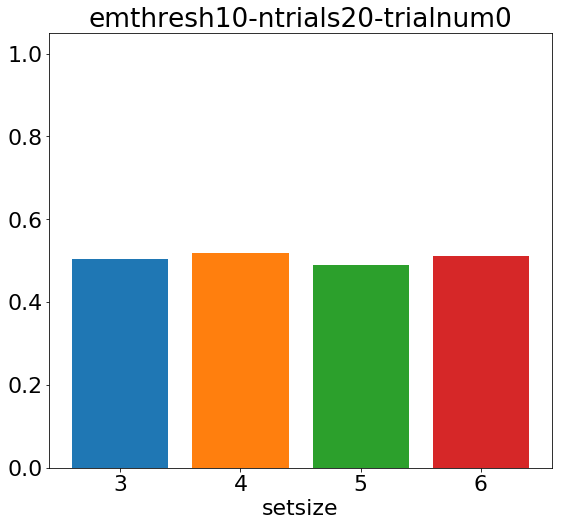

In [151]:
emL = range(11)
ntL = [2,3,4,5,10,15,20]
ssL = [3,4,5,6]
seed = '*'
trep = 100000

# ntL = [3]
# ssL = [3,5]
# emL = [0]
trialnum = 0

for emthresh,ntrials in itertools.product(emL,ntL):
  plt.close('all')
  plt.figure(figsize=(len(ssL)+5,8))
  ax = plt.gca()
  ax.set_ylim(0,1.05)
  ax.set_xlabel('setsize')

  for setsize in ssL:
    gfpath = 'LSTM_25-emthresh_%s-ntrials_%s-setsize_%s-seed_%s-tr_%s-evscore.npy'%(emthresh,ntrials,setsize,seed,trep)
    fpathL = glob('model_data/IRsweep/'+gfpath)
    if not len(fpathL): continue
    nsubs = len(fpathL)
    acc = -np.ones([nsubs,ntrials])
    for sid,fpath in enumerate(fpathL):
      print(fpath)
      sacc = np.load(fpath).mean(0)
      acc[sid] = sacc
    M = acc.mean(0)[trialnum]
    S = acc.std(0)[trialnum]/np.sqrt(nsubs)
    # subject accuracy per trial
    ax.bar(setsize,M,yerr=S)
  title = 'emthresh%i-ntrials%i-trialnum%i'%(emthresh,ntrials,trialnum)
  ax.set_title(title)
  plt.savefig('figures/IRsweep/setsize/'+title+'-trep%i'%trep)
    
    
  

### proactive interference
- later trials should have lower performance due to PI buildup

2 3 (2, 2)
2 5 (2, 2)
5 3 (2, 5)
5 5 (2, 5)
2 3 (1, 2)
2 5 (1, 2)
5 3 (1, 5)
5 5 (1, 5)


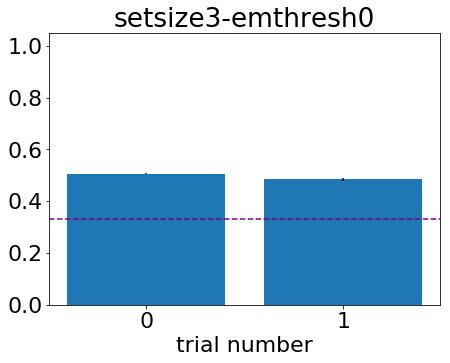

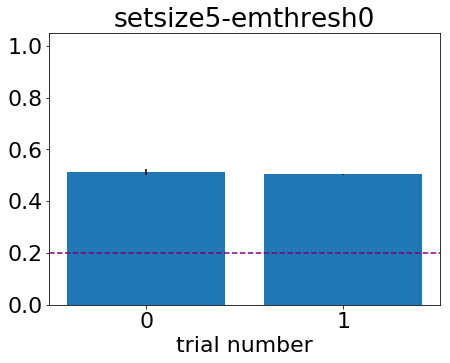

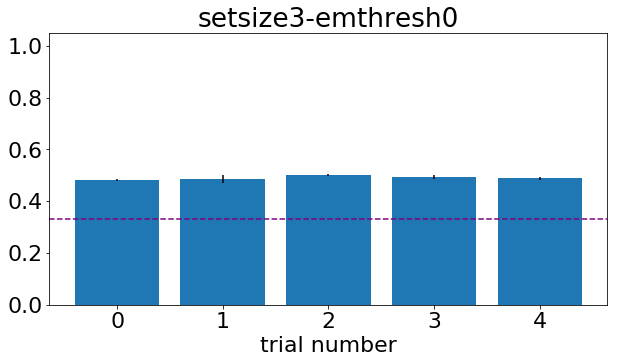

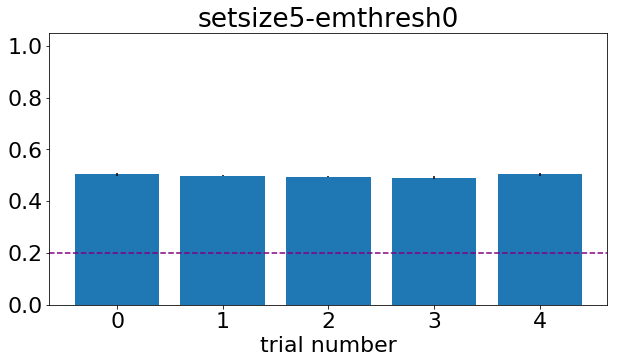

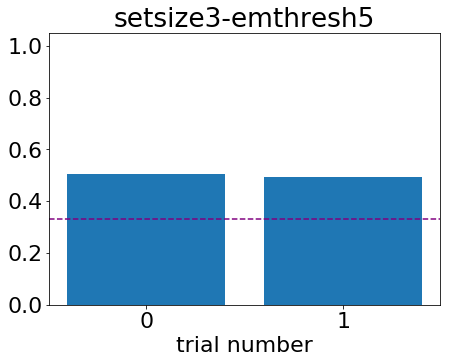

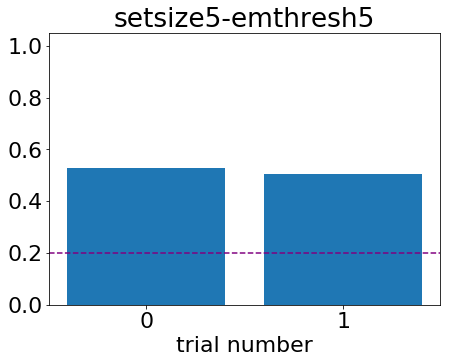

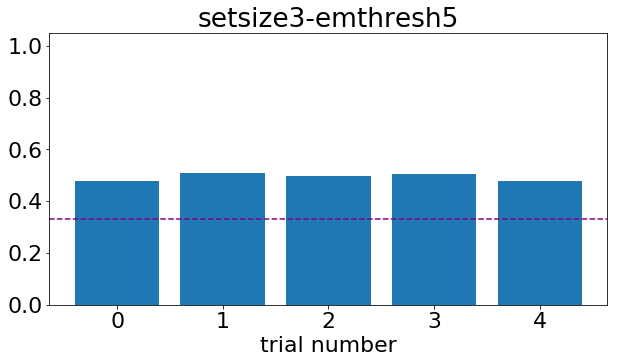

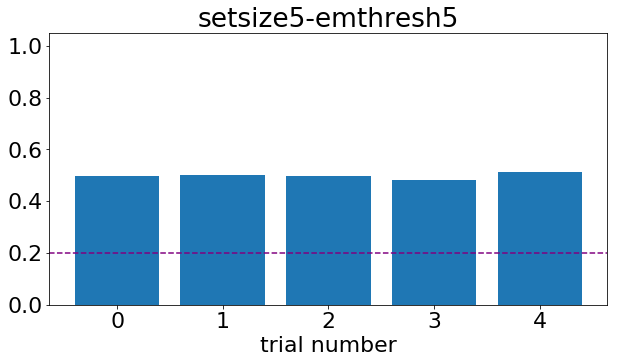

In [60]:
emL = range(11)
ntL = [2,3,4,5,10,15,20]
ssL = [3,4,5,6]
seed = '*'
trep = 200000

ntL = [2,5]
ssL = [3,5]
emL = [0,5]

plt.close('all')
for emthresh,ntrials,setsize in itertools.product(emL,ntL,ssL):
  gfpath = 'LSTM_25-emthresh_%s-ntrials_%s-setsize_%s-seed_%s-tr_%s-evscore.npy'%(emthresh,ntrials,setsize,seed,trep)
  fpathL = glob('model_data/IRsweep/'+gfpath)
  if not len(fpathL): continue
  # load data from every subject
  saccL = []
  for fpath in fpathL:
    sacc = np.load(fpath)
    saccL.append(sacc)
  # subject accuracy per trial
  acc = np.array(saccL).mean(1) # nsubs x ntrials
  print(ntrials,setsize,acc.shape)
  # mean over subjects
  M = acc.mean(0) # ntrials (mean accuracy per trial)
  S = acc.std(0)/np.sqrt(len(acc))
  # plot
  plt.figure(figsize=(ntrials+5,5))
  ax = plt.gca()
  ax.bar(range(len(M)),M,yerr=S)
  ax.set_xticks(range(len(M)))
  ax.set_xticklabels(range(len(M)))
  ax.axhline(1/setsize,c='purple',ls='--')
  title = 'setsize%i-emthresh%i'%(setsize,emthresh) 
  ax.set_title(title)
  ax.set_ylim(0,1.05)
  ax.set_xlabel('trial number')
  plt.savefig('figures/IRsweep/bar_trial_acc/'+title+'-treps%i'%trep)
  
  



# FROM PARENT BRANCH: serial recall

- serial recall regression problem
- list of items is presented, same list needs to be returned

- two approaches:
    - pure lstm, multi-trial, context drifts on 2 timescales
        - set-size arises from PI and serial order estimate failures
    - lstm+EM, single item retrieved at a time, retrieved item used to query EM
        - memory IOR is hard coded



### todo
- train model with true current context

In [164]:
sedim = 9
task = SerialRecallTask(sedim)
stsize = 30
net = SerialRecallEM(sedim,stsize)

In [165]:
training = True
neps = 50000

ntrials = 4
setsize = 5

lossop = tr.nn.MSELoss()
optiop = tr.optim.Adam(net.parameters(), lr=0.001)

loss = -np.ones(neps)

# data generating option:
C,S,Y = task.gen_ep_data(ntrials,setsize)
seqlen = len(C)
# loop
score = -np.ones([neps,seqlen])    
for ep in range(neps):
#   if ep%(neps/10)==0:
#     if verb:print(ep/neps)
  # gen stim
  C,S,ytarget = task.gen_ep_data(ntrials,setsize)
  # forward prop
  yhat = net(C,S)
  # reshape
  ytarget = ytarget.view(-1,sedim)
  yhat = yhat.view(-1,sedim)
  # backprop
  eploss = 0
  for tstep in range(seqlen):
    prloss = lossop(yhat[tstep],ytarget[tstep])
    eploss += prloss
    optiop.zero_grad()
    prloss.backward(retain_graph=True)
    optiop.step()
  loss[ep] = eploss
  



Text(0.5,0,'epoch')

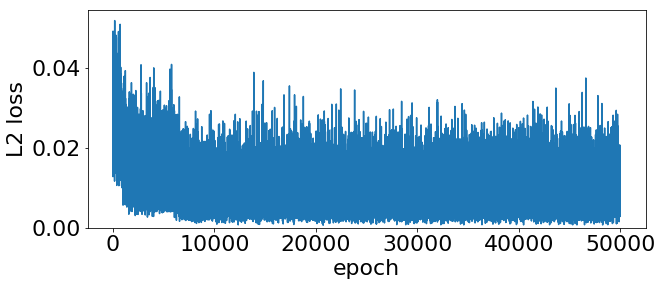

In [167]:
plt.figure(figsize=(10,4))
plt.plot(loss)
plt.ylim(0)
# plt.xlim(-100,5100)
plt.ylabel('L2 loss')
plt.xlabel('epoch')

Text(0.5,0,'epoch')

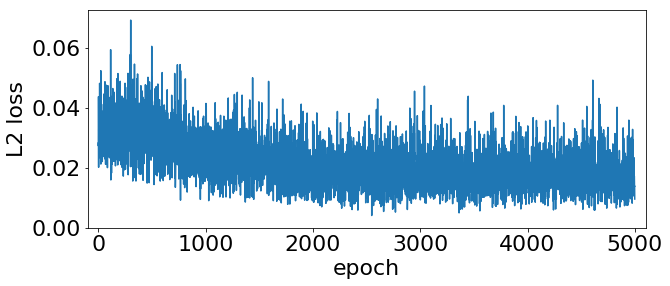

In [123]:
plt.figure(figsize=(10,4))
plt.plot(loss)
plt.ylim(0)
plt.xlim(-100,5100)
plt.ylabel('L2 loss')
plt.xlabel('epoch')

Text(0.5,0,'time')

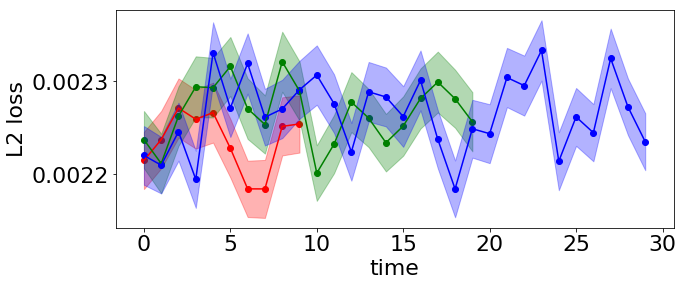

In [168]:
ntrials = 5
# setsize = 4
sdim = net.sedim
eval_lossop = lossop = tr.nn.MSELoss(reduction='none')

plt.figure(figsize=(10,4))

cL = ['r','g','b']
for idx,setsize in enumerate([2,4,6]):

  ## EVALUATE NETWORK
  neps = 5000
  evloss = -np.ones([neps,ntrials*setsize])
  for ep in range(neps):
    S,C,ytarget = task.gen_ep_data(ntrials,setsize)
    yhat = net(S,C)
    eploss = eval_lossop(ytarget.view(-1,sedim),yhat.view(-1,sedim)).mean(-1)
    evloss[ep] = eploss.detach().numpy()

  ## PLOT LOSS
  M = evloss.mean(0)
  T = len(M)
  S = evloss.std(0)/np.sqrt(neps)

  plt.plot(M,c=cL[idx])
  plt.scatter(range(T),M,c=cL[idx])
  plt.fill_between(range(T),M-S,M+S,alpha=.3,color=cL[idx])


plt.ylabel('L2 loss')
plt.xlabel('time')

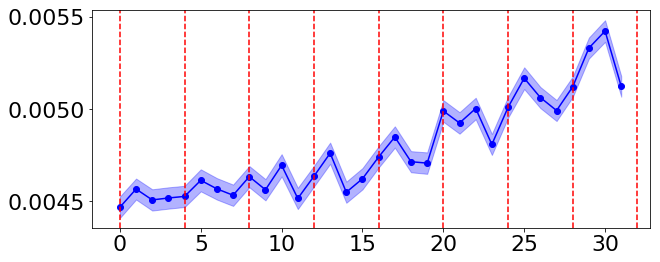

# serial recall 
- ensure forward prop w/o errors

In [44]:
tr.cat([C[0],S[0]],-1).shape

torch.Size([6, 7])

(0, 2.0089862818258246)

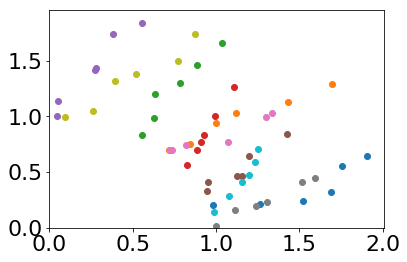

In [34]:
C,S,S = task.gen_ep_data(10,6)
for c in C:
  plt.scatter(c[:,0],c[:,1])
  
plt.ylim(0)
plt.xlim(0)


### model debug

In [37]:
sedim = 5
task = SerialRecallTask(sedim)
indim = 2*sedim
stsize = 20
net = PureEM(indim,stsize)

In [38]:
c,x,y = task.gen_ep_data(2)
x

tensor([[0.0953, 0.0885, 0.0915, 0.1187, 0.0701],
        [0.0062, 0.0653, 0.0265, 0.1406, 0.2232]])

In [39]:
c,x,y

(tensor([[0.0953, 0.1839, 0.2753, 0.3940, 0.4641],
         [0.0062, 0.0715, 0.0980, 0.2387, 0.4619]]),
 tensor([[0.0953, 0.0885, 0.0915, 0.1187, 0.0701],
         [0.0062, 0.0653, 0.0265, 0.1406, 0.2232]]),
 tensor([[0.0953, 0.0885, 0.0915, 0.1187, 0.0701],
         [0.0062, 0.0653, 0.0265, 0.1406, 0.2232]]))

rn


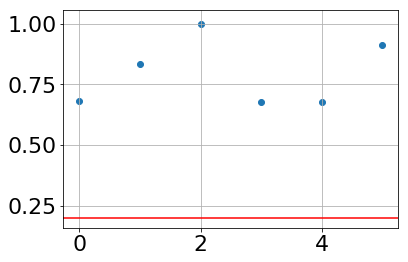

In [54]:
setsize = 6
# temp = 1/(setsize-1)
C,S,Y = task.gen_ep_data(setsize)
# C = np.concatenate([C,S],-1)
x_t = np.array(C[2])
# x_t = np.zeros_like(C[0])
C = np.array(C)
sim = 1-pairwise_distances([x_t],C,metric='euclidean').squeeze()
# sim = np.exp(sim**temp)/np.exp(sim**temp).sum()
# plt.yticks(np.arange(0,1.01,.1))
plt.grid(True)
plt.axhline(1/(setsize-1),c='r')
plt.scatter(range(len(sim)),sim)

## run model

In [2]:
def run_model(net,gen_data_fn,neps,training=False,verb=False):
  """ gen_data_fn: callable that generates a trial of data (embedded)
  """
  lossop = tr.nn.CrossEntropyLoss()
  optiop = tr.optim.Adam(net.parameters(), lr=0.001)
  # data generating option:
  C,X,Y = gen_data_fn()
  seqlen = len(C)
  # loop
  score = -np.ones([neps,seqlen])    
  for ep in range(neps):
    if ep%(neps/10)==0:
      if verb:print(ep/neps)
    # gen stim
    context,stim,ytarget = gen_data_fn()
    # forward prop
    yhat = net(context,stim)
    score[ep] = tr.argmax(tr.softmax(yhat,-1),-1).squeeze() == ytarget
    if training:
      for tstep in range(seqlen):
        loss = lossop(yhat[tstep],ytarget[:,tstep])
        optiop.zero_grad()
        loss.backward(retain_graph=True)
        optiop.step()
  return score



In [3]:
nback=2
ntokens=5
cdrift=0.5
cdim=5
sedim=10
indim=cdim+sedim
stsize=20

task = NbackTask_PureEM(nback=nback,ntokens=ntokens,cdrift=.5,cdim=5,sedim=10)
net = PureEM(nback,indim,stsize,mthresh=.95,seed=132,debug=False)

In [4]:
neps = 2000
seqlen = 10

gen_rand_trials = lambda: task.gen_ep_data(seqlen)
trsc = run_model(net,gen_rand_trials,neps,training=True,verb=False)

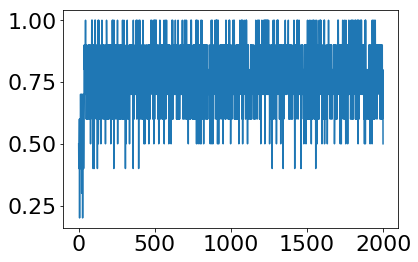

In [5]:
plt.plot(trsc.mean(1))

In [6]:
evsc = run_model(net,gen_rand_trials,500,training=False,verb=False)

(0.5, 1)

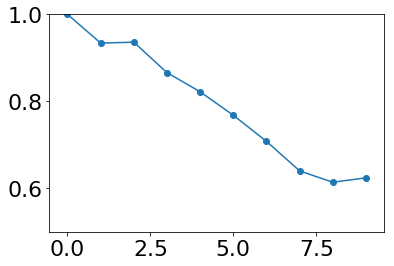

In [7]:
M = evsc.mean(0)
plt.plot(M)
plt.scatter(range(len(M)),M)
plt.ylim(0.5,1)

In [8]:
seqlen=10
evsc = run_model(net,gen_rand_trials,1,training=False,verb=False)

# properties of context drifts

### two step (timescales) context drift
- trial context sampled from first quadrant of unit circle
- linear drift starting from trial context 

## solar drift 2 (multi-trial)
- trial shift
- probe drift

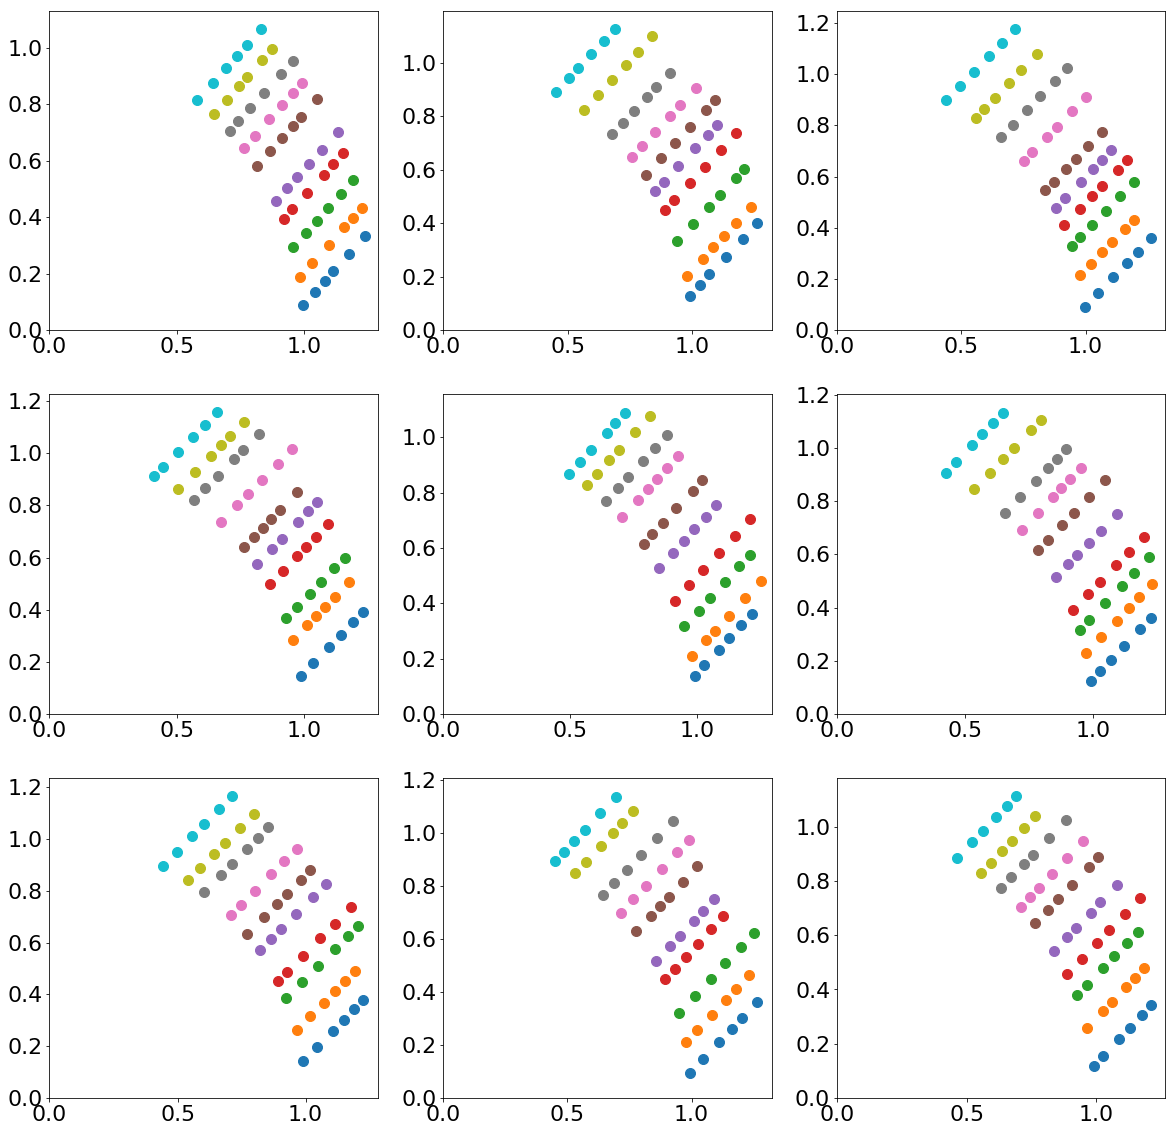

In [114]:
ntrials = 10
ntsteps = 6

# deltas
tstep_drift = lambda: (np.array([1,1]) + np.random.uniform(0,1))/30
trial_shift = lambda: np.random.uniform(0.07,0.15)

fig,axarr = plt.subplots(3,3,figsize=(20,20))

for idx,ax in enumerate(axarr.reshape(-1)):
  # drift shift loop
  context_arr = -np.ones([ntrials,ntsteps,2])
  th = 0
  for trial in range(ntrials):
    th += trial_shift()
    context_t = np.array([np.cos(th),np.sin(th)])
    for tstep in range(ntsteps):
      context_arr[trial,tstep] = context_t
      context_t += tstep_drift()

  for ct in context_arr:
    ax.scatter(ct[:,0],ct[:,1],s=100)

  ax.set_ylim(0)
  ax.set_xlim(0)
plt.savefig('figures/serial_recall/solar_drift-multi_trial_low_noise')

## solar drift 1

In [ ]:
def solar_cdrift():
  # sample initial point
  x_init = np.random.uniform(0,1,[2])
  x_init /= np.linalg.norm(c)
  edim = x_init.shape[-1]
  arr = -np.ones([ntrials,edim])
  x = x_init
  for step in range(ntrials):
    arr[step] = x
    delta_t = np.random.normal(delta_M,cstd,[edim])
    x += np.abs(delta_t)
  return arr

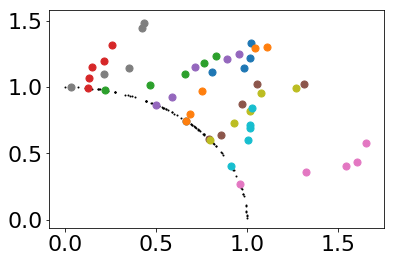

In [5]:
ax = plt.gca()

def sample_trial_context():
  c = np.random.uniform(0,1,[2])
  c /= np.linalg.norm(c)
  return c

def sample_probe_drift(x_init,ntrials,delta_M=.1,cstd=0.1):
    """ 
    drifts ~N(1,self.cstd)
    returns a context embedding matrix [ntrials,cedim]
    """
    edim = x_init.shape[-1]
    arr = -np.ones([ntrials,edim])
    x = x_init
    for step in range(ntrials):
      arr[step] = x
      delta_t = np.random.normal(delta_M,cstd,[edim])
      x += np.abs(delta_t)
    return arr
  
def solar_cdrift(ntrials,delta_M=.1,cstd=0.1):
  # sample initial point
  x_init = np.random.uniform(0,1,[2])
  x_init /= np.linalg.norm(x_init)
  edim = x_init.shape[-1]
  arr = -np.ones([ntrials,edim])
  x = x_init
  for step in range(ntrials):
    arr[step] = x
    delta_t = np.random.normal(delta_M,cstd,[edim])
    x += np.abs(delta_t)
  return arr
  
# make sun
for i in range(100):
  x = sample_trial_context()
  ax.scatter(x[0],x[1],c='k',s=1)

# sample 10 solar drifts
for i in range(10):
#   context_init = sample_trial_context()
#   context = sample_probe_drift(context_init,5)
  context = solar_cdrift(5)
  ax.scatter(context[:,0],context[:,1],s=50)

# plt.savefig('figures/solar_cdrift')

### context drift on sphere: cosine on context retrieves local neighborhood 

In [150]:
def sphere_drift(ntrials,noise=0.05):
    """
    drift on a two dimensional sphere 
    returns C [ntrials,2]
    """
    th = np.pi/(2*ntrials) # drift rate
    R = np.array([[np.cos(th),-np.sin(th)],
                  [np.sin(th),np.cos(th)]])
    x = np.array([1,0]) # initial vector
    C = np.zeros([ntrials,2]) # context matrix
    for i in range(ntrials):
      x = R.dot(x) + np.random.normal(0,noise)
      x = x/np.linalg.norm(x)
      C[i] = x
    return C

# C = sphere_drift(10,.05)
# plt.scatter(C[:,0],C[:,1],c=plt.get_cmap('Reds')(20*np.arange(len(C))))


(10, 2) (10, 3)


Text(0.5,1,'drift process')

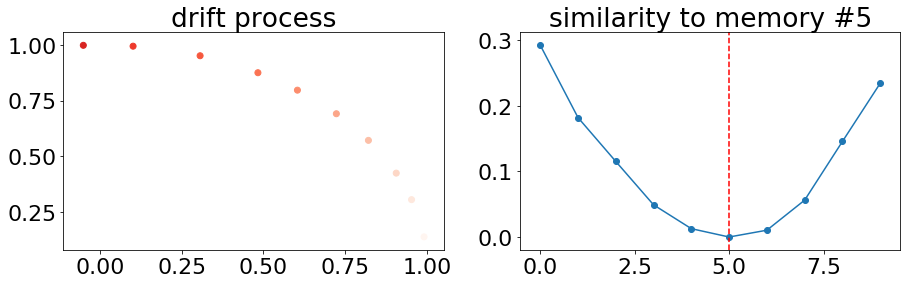

In [159]:
setsize = 10
sdim=3

C = sphere_drift(setsize)
S = np.random.uniform(0,1,[setsize,sdim])
print(C.shape,S.shape)
# C = np.concatenate([C,S],-1)

r_t = 5
c_t = C[r_t]

sim = pairwise_distances([c_t],C,metric='cosine')
sim = sim.squeeze()
fig,axarr = plt.subplots(1,2,figsize=(15,4))
axarr[1].axvline(r_t,c='r',ls='--')
axarr[1].plot(sim)
axarr[1].scatter(range(len(sim)),sim)
axarr[0].scatter(C[:,0],C[:,1],c=plt.get_cmap('Reds')(20*np.arange(len(C))))
axarr[1].set_title('similarity to memory #5')
axarr[0].set_title('drift process')
# plt.savefig('figures/serial_recall/2Dsphere_context_drift')

### cumsum drift, eucledian retrieval on cat([s,t])

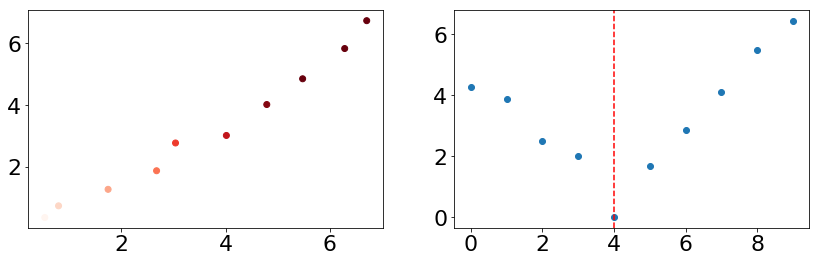

In [3]:
fig,axarr = plt.subplots(1,2,figsize=(14,4))
setsize=10
sdim = 4

S = np.random.uniform(0,1,[setsize,sdim])
C = np.cumsum(np.abs(S),0)
MK = np.concatenate([C,S],-1)

ax = axarr[0]
ax.scatter(C[:,0],C[:,1],c=plt.get_cmap('Reds')(40*np.arange(len(C))))

ax = axarr[1]
r_t = 4
sim = pairwise_distances([MK[r_t]],MK,metric='euclidean').squeeze()
ax.scatter(range(len(sim)),sim)
ax.axvline(r_t,c='r',ls='--')

### orthogonal cumsum context drift

In [ ]:
M = np.random.randn(2,3)
U,M,V = np.linalg.svd(M)
A = np.matmul(U.T,U)

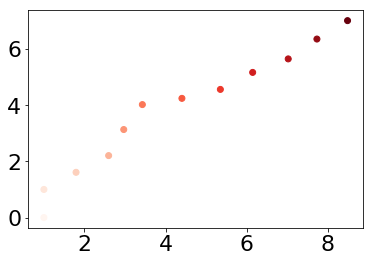

In [78]:
for i in range(10):
  a,b = np.abs(np.random.randn(2))
  P = a*A[:,0:1]+b*A[:,1:2]
  P = P/np.linalg.norm(P)
  A = np.concatenate([A,P],1)
  
C = np.cumsum(A,1).T
plt.scatter(C[:,0],C[:,1],c=np.arange(len(C))+10,cmap=plt.get_cmap('Reds'))

### under what conditions of the stimulus matrix, will the context be a gradual drift?
- as long as non-negative

### how can I use stim to query context, and get neighborhood of stim?
- ??